# Predicting Price with Size, Location, and Neighborhood in  🇦🇷

# Welcome 

# 1. Prepare Data 🔍

### Import 

In [ ]:
from glob import glob
import pandas as pd
import seaborn as sns
import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

##### Wrangle method 

In [ ]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop Features with more half of missing values
    df.drop(columns=["floor","expenses"], inplace=True)
    
    # Drop Features Low-High Cardinality
    df.drop(columns=["operation","property_type", "currency", "properati_url"], inplace=True)
    
    # Drop Features may represent the leakage
    df.drop(columns=["price",
                    "price_aprox_local_currency", 
                     "price_per_m2",
                     "price_usd_per_m2",], inplace=True)
    
    # Drop Features with multicorrilaty
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
 
    return df

In [ ]:
# Import all files of buenos-aires
files = glob("data/buenos-aires-real-estate-*.csv")
# Create a list contains all files
frames = []
for file in files:
    frames.append(wrangle(file))
frames
# Create a dataframe of frames
df = pd.concat(frames, ignore_index=True)
df.head()

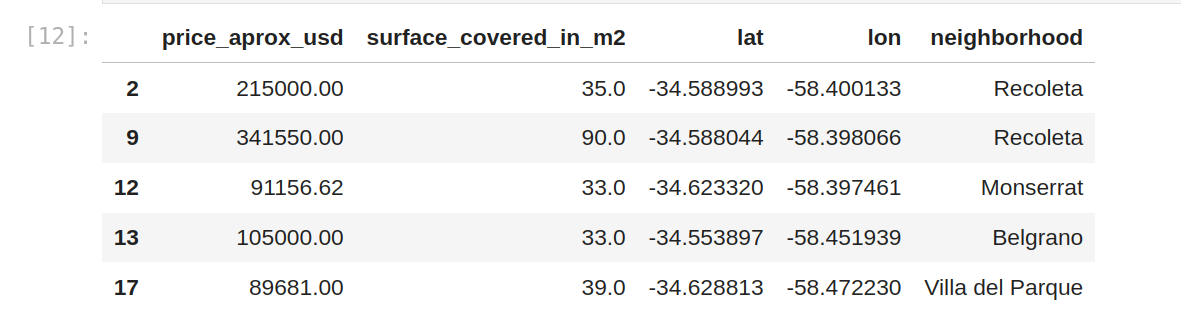

## Explore 

In [ ]:
df_numbers = df.select_dtypes(include="object").nunique()
df_numbers

In [ ]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

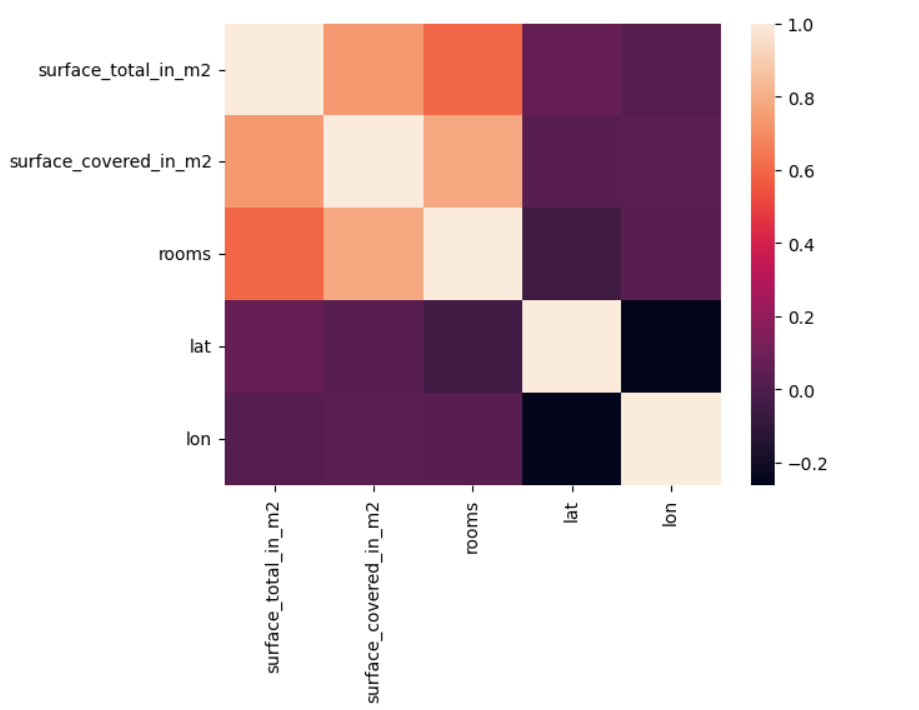

We will modify our wrangle method deleting columns so that there are no strongly correlated features in our feature matrix.

After deletion of the not neccesserly columns 

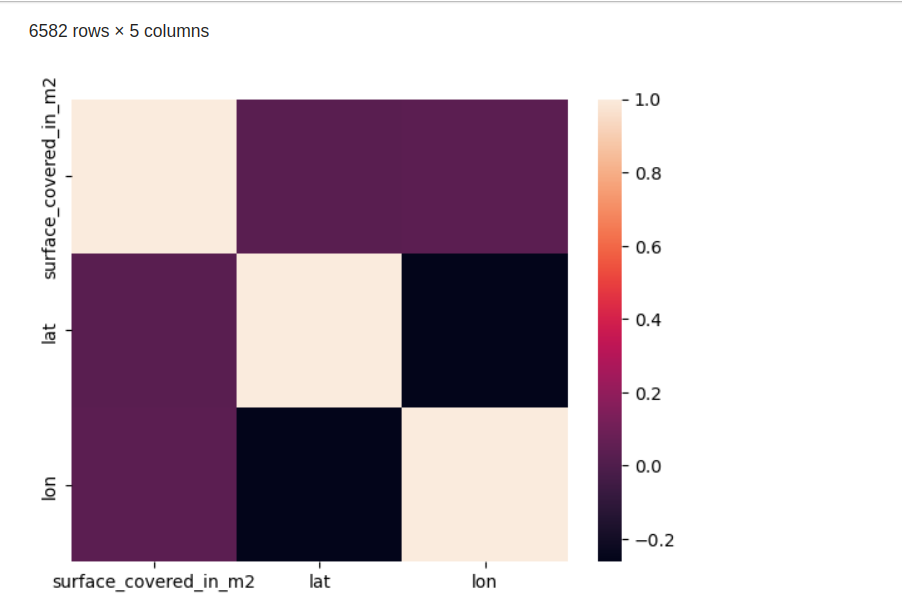

## Split Data 

In [ ]:
# Target (that's what we want predict) 
target = "price_aprox_usd"
# features (we will base on those features to predict the price)
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
# y_train is the target which is price_aprox_usd
y_train = df[target]
# X_train are the features which the lat & lon and surface and neighborhood
X_train = df[features]

# 2. Build Model

### 2.1. Baseline 📈

In [ ]:
# Calculate the baseline
y_mean = y_train.mean()
y_pred_base_line = [y_mean] * len(y_train)
# Mean absolute error
mean_baseline_error = mean_absolute_error(y_train, y_pred_base_line)
# Print the baseline and The mean absolute error
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", round(mean_baseline_error, 2))

### 2.2. Iterate

Create a pipeline model that contains OneHotEncoder, SimpleImputer, and Ridge predictor

In [ ]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

In [ ]:
# Check your work
check_is_fitted(model[-1])

### 2.3. Evaluate

In [ ]:
y_pred_training = model.predict(X_train)
mae_trainig = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", mae_trainig)
y_pred_training

Generate a Series of predictions for X_test

In [ ]:
#  Import files for test focusing on the features we have 
X_test = pd.read_csv("data/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

# 3. Communicate Results 👜

### Prediction Method 

In [ ]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
         "surface_covered_in_m2": area,
         "lat": lat,
         "lon": lon,
         "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df)
    return f"Predicted apartment price: ${prediction}"

In [ ]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $[250775.11270377]'

### Deploy

In [ ]:
# Deploy our model in a html widgets
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

Screen for the our model in the Widgets.

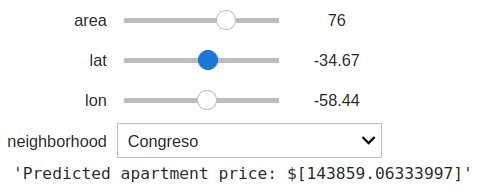